In [1]:
import pandas as pd
import numpy as np
# from sklearn.linear_model import LinearRegression
from itertools import product
import warnings
warnings.filterwarnings("ignore")
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
class ModelGroupSpecs:
    def __init__(self, ar_orders, desired_model_groups):
        self.ar_orders = ar_orders
        self.desired_model_groups = desired_model_groups

    def get_all_possible_combinations(self, model_group, MG_ar_orders, MG_regressors):
        return list(product(model_group, MG_ar_orders, MG_regressors))

    def create_functional_sets(self):
        output = []
        if "AR" in self.desired_model_groups:
            # MG1 = Model Group 1: AR models.

            self.AR_models = self.get_all_possible_combinations(
                model_group=['AR'],
                MG_ar_orders=self.ar_orders,
                MG_regressors=[None])
            output.append(self.AR_models)

        if "OLS" in self.desired_model_groups:
            # MG2N = Model Group 2N: Single Variable Exogenous OLS

            self.OLS_models = self.get_all_possible_combinations(
                model_group=['OLS'],
                MG_ar_orders=[None],#'log_new_vaccines_per_capita	', 
                MG_regressors=['log_new_people_vaccinated_per_capita', 
                                'delta_cases_per_capita_United Kingdom', 'delta_cases_per_capita_Germany', 'delta_cases_per_capita_France',
                                'full_lockdown', 'full_lockdown.l30', 'full_lockdown.l45',
                                'max_tp', 'min_tp', 'rain', 'humidity',
                                'day_of_the_week', 'season', 'trend'])
            output.append(self.OLS_models)


        if "ARX" in self.desired_model_groups:
            # MG2T and MG3T: Introducing lagged dependent terms to the previous model specifications.

            self.ARX_models = self.get_all_possible_combinations(
                model_group=['ARX'],
                MG_ar_orders=self.ar_orders,
                MG_regressors=['log_new_people_vaccinated_per_capita', 
                                'delta_cases_per_capita_United Kingdom', 'delta_cases_per_capita_Germany', 'delta_cases_per_capita_France',
                                'full_lockdown', 'full_lockdown.l30', 'full_lockdown.l45',
                                'max_tp', 'min_tp', 'rain', 'humidity',
                                'day_of_the_week', 'season', 'trend'])
            output.append(self.ARX_models)

        # Returning the functional sets to be deployed.
        return output

def naming(model_group, ar_order, regressor):
    return f"{model_group}, AR{ar_order}, Regressor = {regressor}"

In [3]:
ar_orders = np.arange(1, 5)

In [4]:
models = ModelGroupSpecs(ar_orders, ['AR', "OLS", "ARX"])

In [5]:
model_groups = models.create_functional_sets()

In [6]:
combined = pd.read_csv("Combined_Dataset.csv", index_col="Unnamed: 0")

In [7]:
combined.set_index("date", inplace = True)

In [8]:
y_var = 'delta_deaths_per_capita'

In [9]:
from statsmodels.tsa.arima.model import ARIMA
from tqdm import tqdm
import statsmodels.formula.api as sm

In [10]:
combined['delta_deaths_per_capita_l1'] = combined['delta_deaths_per_capita'].shift(1).fillna(0)

In [11]:
combined.rename(columns = {"delta_deaths_per_capita_United Kingdom": "delta_deaths_per_capita_United_Kingdom"}, inplace = True)

In [12]:
combined['delta_deaths_per_capita_l2']= combined['delta_deaths_per_capita'].shift(2).fillna(0)
combined['delta_deaths_per_capita_l3']= combined['delta_deaths_per_capita'].shift(3).fillna(0)
combined['delta_deaths_per_capita_l4']= combined['delta_deaths_per_capita'].shift(4).fillna(0)
combined['delta_deaths_per_capita_l5']= combined['delta_deaths_per_capita'].shift(5).fillna(0)
combined['delta_deaths_per_capita_l6']= combined['delta_deaths_per_capita'].shift(6).fillna(0)
combined['delta_deaths_per_capita_l7']= combined['delta_deaths_per_capita'].shift(7).fillna(0)
combined['delta_deaths_per_capita_l14']= combined['delta_deaths_per_capita'].shift(14).fillna(0)
combined['delta_deaths_per_capita_l30']= combined['delta_deaths_per_capita'].shift(30).fillna(0)

In [13]:
model=sm.ols(f'delta_deaths_per_capita ~ delta_deaths_per_capita_United_Kingdom +  delta_deaths_per_capita_l4  +  delta_deaths_per_capita_l7 +  delta_deaths_per_capita_l14 +  delta_deaths_per_capita_l30', data= combined)
results=model.fit(cov_type='HAC',
                                            cov_kwds={'maxlags':12,'use_correction':True})




In [14]:
for table in results.summary().tables:
    print(table.as_latex_tabular())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}    & delta\_deaths\_per\_capita & \textbf{  R-squared:         } &     0.645   \\
\textbf{Model:}            &            OLS             & \textbf{  Adj. R-squared:    } &     0.642   \\
\textbf{Method:}           &       Least Squares        & \textbf{  F-statistic:       } &     53.62   \\
\textbf{Date:}             &      Wed, 11 May 2022      & \textbf{  Prob (F-statistic):} &  4.45e-46   \\
\textbf{Time:}             &          21:15:13          & \textbf{  Log-Likelihood:    } &    7108.5   \\
\textbf{No. Observations:} &              611           & \textbf{  AIC:               } & -1.420e+04  \\
\textbf{Df Residuals:}     &              605           & \textbf{  BIC:               } & -1.418e+04  \\
\textbf{Df Model:}         &                5           & \textbf{                     } &             \\
\textbf{Covariance Type:}  &            HAC             & \textbf{                     } &             \\


In [15]:
data = pd.read_csv("owid-covid-data_Ireland.csv", index_col = "date")
data = data[(data.index >= "2021-11-01") & (data.index <= "2022-03-01")]
ireland_data = data[data['location'] == "Ireland"]
ireland_data.index = pd.DatetimeIndex(ireland_data.index)
ireland_data['delta_cases_per_capita'] = ireland_data['total_cases'].divide(ireland_data['population']).diff().fillna(0)
ireland_data['delta_deaths_per_capita'] = ireland_data['total_deaths'].divide(ireland_data['population']).diff().fillna(0)

In [16]:
ireland_data

,iso_code,continent,location,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,...,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,delta_cases_per_capita,delta_deaths_per_capita
date,,,,,,,,,,,,,,,,,,,,,
2021-11-01,IRL,Europe,Ireland,448449.0,2855.0,2389.571,5436.0,0.0,9.571,89997.520,...,NaN,2.96,82.3,0.955,NaN,NaN,NaN,NaN,0.000000,0.000000e+00
2021-11-02,IRL,Europe,Ireland,452172.0,3723.0,2610.000,5436.0,0.0,9.571,90744.674,...,NaN,2.96,82.3,0.955,NaN,NaN,NaN,NaN,0.000747,0.000000e+00
2021-11-03,IRL,Europe,Ireland,455346.0,3174.0,2831.429,5492.0,56.0,8.000,91381.652,...,NaN,2.96,82.3,0.955,NaN,NaN,NaN,NaN,0.000637,1.123843e-05
2021-11-04,IRL,Europe,Ireland,458370.0,3024.0,2892.286,5492.0,0.0,8.000,91988.527,...,NaN,2.96,82.3,0.955,NaN,NaN,NaN,NaN,0.000607,0.000000e+00
2021-11-05,IRL,Europe,Ireland,462273.0,3903.0,3086.857,5492.0,0.0,8.000,92771.805,...,NaN,2.96,82.3,0.955,NaN,NaN,NaN,NaN,0.000783,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-25,IRL,Europe,Ireland,1292212.0,4304.0,3869.714,6475.0,4.0,8.286,259329.098,...,NaN,2.96,82.3,0.955,NaN,NaN,NaN,NaN,0.000864,8.027447e-07
2022-02-26,IRL,Europe,Ireland,1292212.0,0.0,3869.714,6475.0,0.0,8.286,259329.098,...,NaN,2.96,82.3,0.955,NaN,NaN,NaN,NaN,0.000000,0.000000e+00
2022-02-27,IRL,Europe,Ireland,1292212.0,0.0,3869.714,6475.0,0.0,8.286,259329.098,...,NaN,2.96,82.3,0.955,NaN,NaN,NaN,NaN,0.000000,0.000000e+00


In [17]:
test_data = pd.read_csv("test_data.csv", index_col = "date")

In [18]:
test_data['delta_deaths_per_capita'] = ireland_data['delta_deaths_per_capita']

In [19]:
lags = [1,2,3,4,5,6,7,14,30]
cols = [f'delta_deaths_per_capita_l{i}' for i in lags]
test_data['delta_deaths_per_capita_l1'] = test_data['delta_deaths_per_capita'].shift(1)
test_data['delta_deaths_per_capita_l2'] = test_data['delta_deaths_per_capita'].shift(2)
test_data['delta_deaths_per_capita_l3'] = test_data['delta_deaths_per_capita'].shift(3)
test_data['delta_deaths_per_capita_l4'] = test_data['delta_deaths_per_capita'].shift(4)
test_data['delta_deaths_per_capita_l5'] = test_data['delta_deaths_per_capita'].shift(5)
test_data['delta_deaths_per_capita_l6'] = test_data['delta_deaths_per_capita'].shift(6)
test_data['delta_deaths_per_capita_l7'] = test_data['delta_deaths_per_capita'].shift(7)
test_data['delta_deaths_per_capita_l14'] = test_data['delta_deaths_per_capita'].shift(14)
test_data['delta_deaths_per_capita_l30'] = test_data['delta_deaths_per_capita'].shift(30)

In [20]:
combined

,delta_deaths_per_capita,delta_cases_per_capita,delta_deaths_per_capita.l1,delta_cases_per_capita.l1,log_new_vaccines_per_capita,log_new_people_vaccinated_per_capita,delta_cases_per_capita_United_Kingdom,delta_deaths_per_capita_United_Kingdom,delta_cases_per_capita_Germany,delta_deaths_per_capita_Germany,...,trend,delta_deaths_per_capita_l1,delta_deaths_per_capita_l2,delta_deaths_per_capita_l3,delta_deaths_per_capita_l4,delta_deaths_per_capita_l5,delta_deaths_per_capita_l6,delta_deaths_per_capita_l7,delta_deaths_per_capita_l14,delta_deaths_per_capita_l30
date,,,,,,,,,,,,,,,,,,,,,
2020-03-01,0.0,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
2020-03-02,0.0,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,5.864491e-07,0.000000e+00,3.933232e-07,0.000000e+00,...,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
2020-03-03,0.0,2.006862e-07,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,8.063675e-07,0.000000e+00,4.529176e-07,0.000000e+00,...,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
2020-03-04,0.0,8.027447e-07,0.000000,2.006862e-07,0.000000e+00,0.000000e+00,8.210287e-07,0.000000e+00,6.197820e-07,0.000000e+00,...,4,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
2020-03-05,0.0,0.000000e+00,0.000000,8.027447e-07,0.000000e+00,0.000000e+00,7.184001e-07,0.000000e+00,1.299158e-06,0.000000e+00,...,5,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-28,0.0,5.213827e-04,0.000013,3.259144e-04,2.693943e-10,1.112052e-10,5.728728e-04,2.433764e-06,3.341698e-04,1.501779e-06,...,607,0.000013,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
2021-10-29,0.0,5.099436e-04,0.000000,5.213827e-04,1.482583e-10,1.046810e-10,6.327639e-04,2.726988e-06,2.940150e-04,1.442185e-06,...,608,0.000000,0.000013,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000008
2021-10-30,0.0,5.952352e-04,0.000000,5.099436e-04,1.034203e-10,8.457030e-11,5.982660e-04,2.433764e-06,2.567685e-04,1.072700e-06,...,609,0.000000,0.000000,0.000013,0.000000,0.000000,0.0,0.0,0.0,0.000000


In [21]:
import math
from datetime import datetime, timedelta

for lag in lags:
    column = f'delta_deaths_per_capita_l{lag}'
    for row in test_data[column].index:
        if math.isnan(test_data.loc[row, column]):
            date_to_fill = str(pd.to_datetime(row)-timedelta(lag))[:10]
            try:

                test_data.loc[row, column] = combined.loc[date_to_fill, 'delta_deaths_per_capita']
            except:
                test_data.loc[row, column] = test_data.loc[date_to_fill, 'delta_deaths_per_capita']


In [22]:
combined['delta_deaths_per_capita_United_Kingdom_l1'] = combined['delta_deaths_per_capita_United_Kingdom'].shift(1).fillna(0)

In [23]:
test_data.rename(columns = {"delta_deaths_per_capita_United Kingdom": "delta_deaths_per_capita_United_Kingdom"}, inplace = True)

In [24]:
test_data['delta_deaths_per_capita_United_Kingdom_l1'] = test_data['delta_deaths_per_capita_United_Kingdom'].shift(1).fillna(combined.loc['2021-11-01', 'delta_deaths_per_capita_United_Kingdom'])

In [25]:
model=sm.ols(f'delta_deaths_per_capita ~ delta_deaths_per_capita_United_Kingdom +  delta_deaths_per_capita_l4  +  delta_deaths_per_capita_l7 +  delta_deaths_per_capita_l14 +  delta_deaths_per_capita_l30', data= combined)
ARX=model.fit(cov_type='HAC',
                                            cov_kwds={'maxlags':12,'use_correction':True})


model=sm.ols(f'delta_deaths_per_capita ~ delta_deaths_per_capita_l4  +  delta_deaths_per_capita_l7 +  delta_deaths_per_capita_l14 +  delta_deaths_per_capita_l30', data= combined)
AR=model.fit(cov_type='HAC',
                                            cov_kwds={'maxlags':12,'use_correction':True})

model=sm.ols(f'delta_deaths_per_capita ~ delta_deaths_per_capita_United_Kingdom', data= combined)
OLS=model.fit(cov_type='HAC',
                                            cov_kwds={'maxlags':12,'use_correction':True})

In [26]:
test_data.rename(columns = {"delta_deaths_per_capita_United Kingdom": "delta_deaths_per_capita_United_Kingdom"}, inplace = True)

In [27]:
predictions_ARX = ARX.get_prediction(test_data).summary_frame(alpha = 0.05)['mean']
predictions_AR = AR.get_prediction(test_data).summary_frame(alpha = 0.05)['mean']
predictions_OLS = OLS.get_prediction(test_data).summary_frame(alpha = 0.05)['mean']

In [28]:
actual = test_data['delta_deaths_per_capita']

In [29]:
def line_format(label):
    """
    Convert time label to the format of pandas line plot
    """
    month = label.month_name()[:3]
    if month == 'Jan':
        month += f'\n{label.year}'
    return month

In [30]:
predictions_ARX = pd.DataFrame(predictions_ARX)
predictions_ARX.set_index(actual.index, inplace = True)
predictions_ARX.index = pd.DatetimeIndex(predictions_ARX.index)

predictions_AR = pd.DataFrame(predictions_AR)
predictions_AR.set_index(actual.index, inplace = True)
predictions_AR.index = pd.DatetimeIndex(predictions_AR.index)

predictions_OLS = pd.DataFrame(predictions_OLS)
predictions_OLS.set_index(actual.index, inplace = True)
predictions_OLS.index = pd.DatetimeIndex(predictions_OLS.index)

actual.index = pd.DatetimeIndex(actual.index)

In [31]:
MSE_ARX_times_scaled  = round(float((predictions_ARX.subtract(actual, axis = 0)**2).mean()*100000000), 5)

In [32]:
MSE_AR_times_scaled  = round(float((predictions_AR.subtract(actual, axis = 0)**2).mean()*1000000000), 5)

In [33]:
MSE_OLS_scaled =round(float((predictions_OLS.subtract(actual, axis = 0)**2).mean()*100000000), 5)

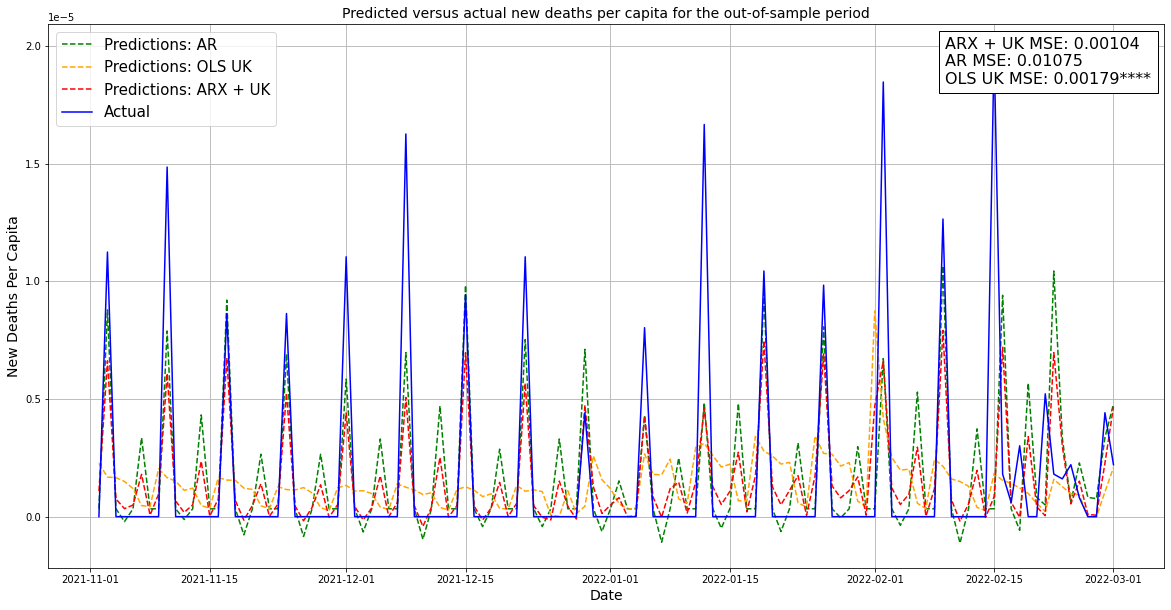

In [39]:
import matplotlib.pyplot as plt

from matplotlib.offsetbox import AnchoredText

fig, ax = plt.subplots()

fig.set_size_inches(20, 10)

ax.plot(predictions_AR, label = 'Predictions: AR', color = 'green', linestyle = '--')
ax.plot(predictions_OLS, label = 'Predictions: OLS UK', color = 'orange', linestyle = '--')
ax.plot(predictions_ARX, label = 'Predictions: ARX + UK', color = 'red', linestyle = '--')

ax.plot(actual, label = "Actual", color = 'blue')

ax.legend(fontsize = 15, loc = 2)
ax.set_xlabel("Date", fontsize = 14)
ax.set_ylabel("New Deaths Per Capita", fontsize = 14)
ax.set_title("Predicted versus actual new deaths per capita for the out-of-sample period", fontsize = 14)
ax.grid('on')

anchored_text = AnchoredText(f"ARX + UK MSE: {MSE_ARX_times_scaled} \nAR MSE: {MSE_AR_times_scaled} \nOLS UK MSE: {MSE_OLS_scaled}****", loc=1,borderpad=0.4,frameon=True, prop = dict(fontsize = '16'))
ax.add_artist(anchored_text)
